### Final Propensity matching results

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load pre matching data

In [5]:
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2.p')
controls = pd.read_pickle(pp_str+'controls.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle('tempHybridSelectionMoreData/random.p')

### Pick Columns for matching

In [6]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [7]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
match_on = all_columns2
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

"""
#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" = 1}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)
"""


Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:328522 before they were:354792
IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None
There were no matches for 1 out of 1604 patients
CPU times: user 1h 12min 44s, sys: 53min 10s, total: 2h 5min 54s
Wall time: 1h 29min 11s


'\n#columns_to_match = columns_to_match + [\'IP_BIN2\', \'ER_BIN2\']\npropensity_func_args = {\'match_on\':columns_to_match, \'neighbors_per_treated\': 5, \'onset\': "CC_DIABETES", "onset_val" = 1}\nmatched0, matched_data0 = matched_population(treated2.copy(), \n                                           controls.copy(),\n                                           propensity_func, \n                                           propensity_func_args)\n'

####  In addition to the previously created matched groups create a random group

In [8]:
Path('./tempHierALL').mkdir(exist_ok = True)
p = './tempHierALL/'
matched_data0.to_pickle(p+'match0.p')
treated2.to_pickle(p+'treated0.p')

In [9]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [10]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [11]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Stats First Month(Treated and Matched Controls)

In [12]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated2, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_data0, all_columns, return_array = True)

CPU times: user 3.93 s, sys: 36.7 ms, total: 3.97 s
Wall time: 3.97 s


### Stats First Month(General Pop and Random)

In [13]:
%%time
pmpm_desc = statistics_first_month(pmpm2, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

CPU times: user 2min 30s, sys: 7.33 s, total: 2min 38s
Wall time: 2min 38s


In [14]:
%%time
conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 30.3 ms, sys: 0 ns, total: 30.3 ms
Wall time: 30.1 ms


## Statistics on matching date

In [15]:
conds_first.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.206           50.313  -0.305  0.760             44.311   47.606
ALLOW_AMT        693.750          577.030   2.393  0.017           1065.926  648.803
MBR_GNDR           0.206            0.211  -0.489  0.625              0.443    0.431
CC_TOBACCO         0.061            0.070  -1.272  0.203              0.074    0.098
CC_PRESSURE        0.001            0.003  -0.960  0.337              0.007    0.007
CC_OBESITY         0.456            0.441   1.103  0.270              0.109    0.228
CC_HYPERTENSION    0.325            0.329  -0.336  0.737              0.208    0.249
CC_HYPOTHYROID     0.095            0.084   1.339  0.181              0.047    0.063
CC_DX_CNT          2.706            2.519   3.206  0.001              1.824    2.344
ACUTE2             0.039            0.032   1.377  0.168              0.063    0.052
ACUTE6             0.112            0.109   0.216  0.829              0.063    0.153
IP_BIN6            0.028            0.026   0.436  0.663              0.021    0.047
ER_BIN6            0.089            0.089   0.001  0.999              0.047    0.116
LOB                0.952            0.950   0.269  0.788              0.756    0.788

In [16]:
full_first

Treated                    Matched Controls                      Test-TC           General Population                         Test-TG                    Random                       Test-TR              
                       mean          std count             mean          std count    t-stat      pval               mean          std   count     t-stat          pval        mean          std count     t-stat          pval
AGE_AT_MIDMONTH   50.205736    12.733903  1604        50.313325    12.836765  7580 -0.305379  0.760085          44.310976    20.053585  356446  11.762030  6.207968e-32   47.606399    19.811819  7876   5.046484  4.583703e-07
ALLOW_AMT        693.750000  2216.211182  1604       577.029947  1666.440624  7580  2.392948  0.016734        1065.926022  6933.418650  356446  -2.149328  3.160904e-02  648.802692  3166.090228  7876   0.542150  5.877276e-01
MBR_GNDR           0.205736     0.404364  1604         0.211214     0.408197  7580 -0.489089  0.624790           0.442749     0.496712  356446 -19.081951  3.914644e-81    0.431056     0.495255  7876 -17.097185  1.439342e-64
CC_TOBACCO         0.061097     0.239583  1604         0.069921     0.255030  7580 -1.271961  0.203419           0.074202     0.262100  356446  -1.998705  4.564109e-02    0.098400     0.297874  7876  -4.714462  2.458070e-06
CC_PRESSURE        0.001247     0.035300  1604         0.002507     0.050006  7580 -0.959556  0.337304           0.007390     0.085645  356446  -2.871419  4.086576e-03    0.006602     0.080991  7876  -2.598386  9.380812e-03
CC_OBESITY         0.456359     0.498247  1604         0.441293     0.496574  7580  1.103279  0.269935           0.108841     0.311440  356446  44.434357  0.000000e+00    0.228035     0.419592  7876  19.209513  1.041149e-80
CC_HYPERTENSION    0.324813     0.468451  1604         0.329156     0.469938  7580 -0.336419  0.736563           0.207717     0.405674  356446  11.525694  9.915163e-31    0.249365     0.432673  7876   6.274847  3.652926e-10
CC_HYPOTHYROID     0.094763     0.292979  1604         0.084433     0.278054  7580  1.338963  0.180616           0.047300     0.212281  356446   8.916454  4.836392e-19    0.063484     0.243847  7876   4.516264  6.370084e-06
CC_DX_CNT          2.706359     2.227360  1604         2.519393     2.098830  7580  3.206069  0.001350           1.824419     2.412274  356446  14.614465  2.345498e-48    2.343702     2.439688  7876   5.504457  3.799632e-08
ACUTE2             0.038653     0.208377  1604         0.031530     0.183594  7580  1.377422  0.168415           0.063258     0.243426  356446  -4.041413  5.314111e-05    0.051549     0.237733  7876  -2.020160  4.339483e-02
ACUTE6             0.111596     0.412699  1604         0.109235     0.394171  7580  0.216147  0.828878           0.063258     0.243426  356446   7.901966  2.753095e-15    0.153377     0.475791  7876  -3.274968  1.060534e-03
IP_BIN6            0.028055     0.199403  1604         0.025858     0.179770  7580  0.436054  0.662808           0.020587     0.141996  356446   2.097153  3.598074e-02    0.046851     0.263725  7876  -2.701482  6.915408e-03
ER_BIN6            0.088529     0.359723  1604         0.088522     0.350598  7580  0.000646  0.999485           0.047286     0.212251  356446   7.732311  1.058846e-14    0.116176     0.402957  7876  -2.548765  1.082613e-02
LOB                0.951995     0.213843  1604         0.950396     0.217140  7580  0.268682  0.788181           0.755775     0.429627  356446  18.281467  1.257397e-74    0.787836     0.408866  7876  15.649481  1.606802e-54

### Statistics Over all dates (treated, controls)

In [17]:
%%time
tr_desc0A = treated2[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data0[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

CPU times: user 734 ms, sys: 2.32 ms, total: 736 ms
Wall time: 735 ms


### Statistics Over all dates (general population, Random)

In [18]:
%%time
pmpm_descA = pmpm2[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

CPU times: user 29.2 s, sys: 2.65 s, total: 31.8 s
Wall time: 31.8 s


In [19]:
%%time
conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)

CPU times: user 29.8 ms, sys: 300 µs, total: 30.1 ms
Wall time: 28.7 ms


In [20]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.837           51.185  -4.040  0.000             50.379   50.236
ALLOW_AMT        782.435          702.270   3.331  0.001            857.856  706.609
MBR_GNDR           0.189            0.197  -2.842  0.004              0.433    0.429
CC_TOBACCO         0.063            0.080  -9.305  0.000              0.102    0.100
CC_PRESSURE        0.002            0.003  -2.701  0.007              0.013    0.008
CC_OBESITY         0.505            0.462  12.428  0.000              0.255    0.286
CC_HYPERTENSION    0.325            0.333  -2.409  0.016              0.329    0.300
CC_HYPOTHYROID     0.095            0.091   2.101  0.036              0.078    0.075
CC_DX_CNT          2.918            2.755  10.783  0.000              2.955    2.759
ACUTE2             0.032            0.034  -1.495  0.135              0.060    0.050
ACUTE6             0.100            0.103  -1.366  0.172              0.168    0.150
IP_BIN6            0.025            0.031  -4.199  0.000              0.055    0.049
ER_BIN6            0.079            0.078   0.272  0.786              0.122    0.111
LOB                0.953            0.944   5.738  0.000              0.802    0.803

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [21]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [22]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [23]:
base_path =  './results/hier_matching_ALL/'
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [24]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

In [25]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


#### remove %%capture to see output

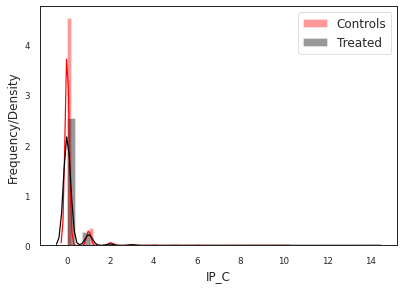

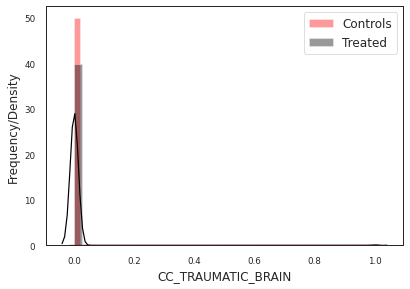

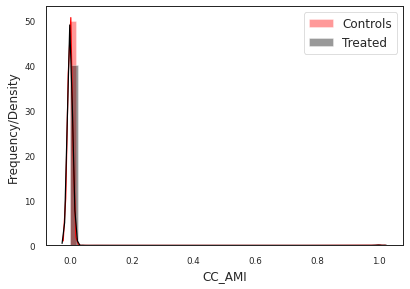

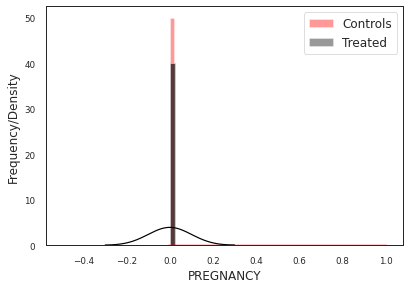

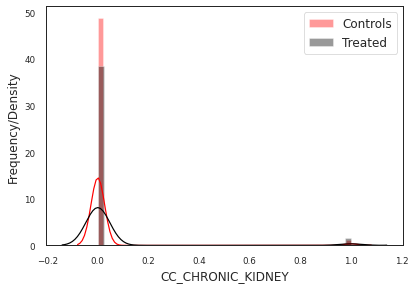

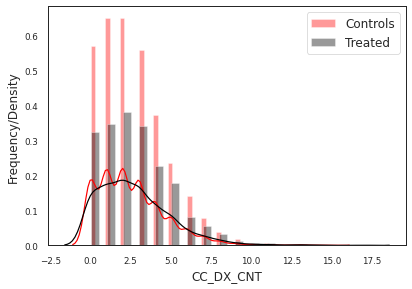

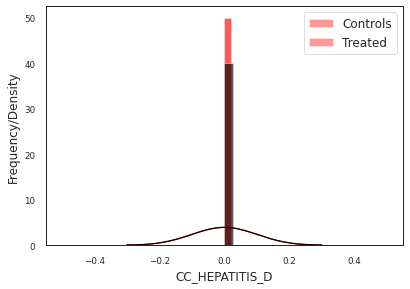

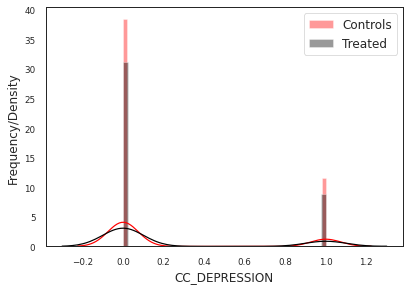

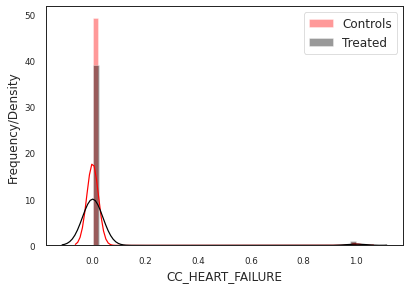

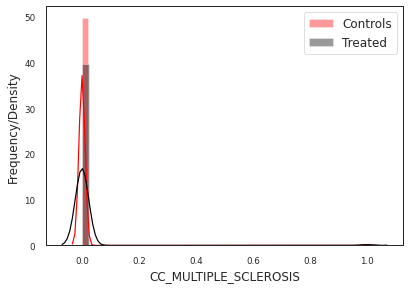

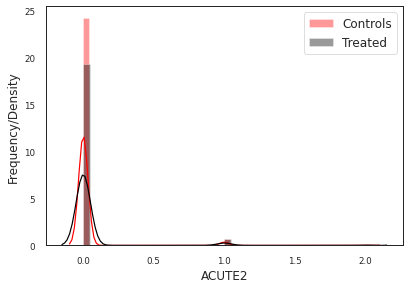

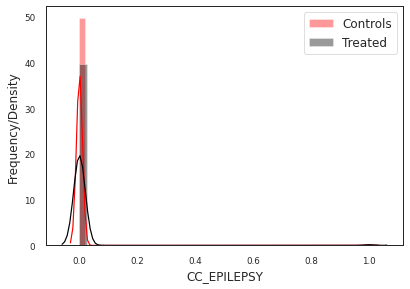

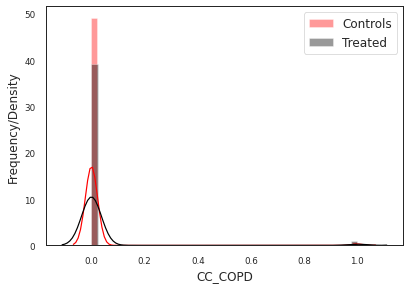

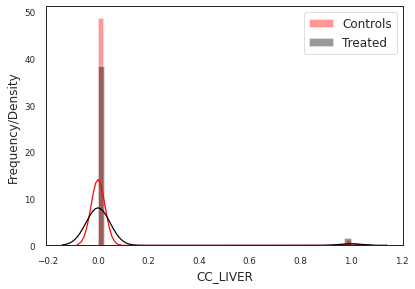

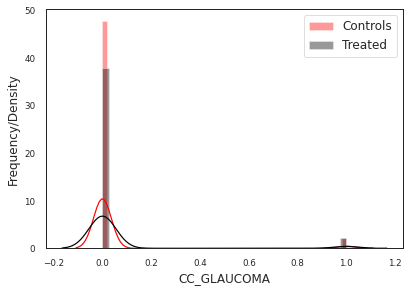

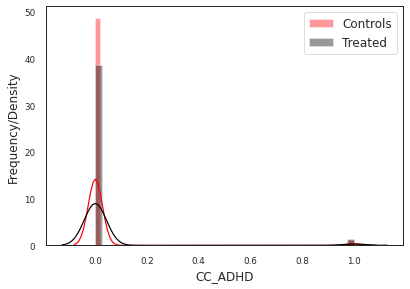

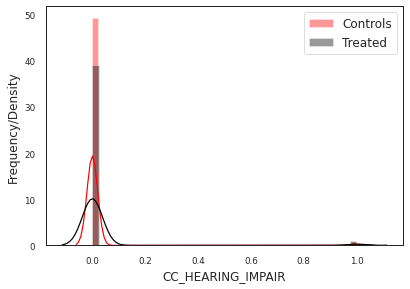

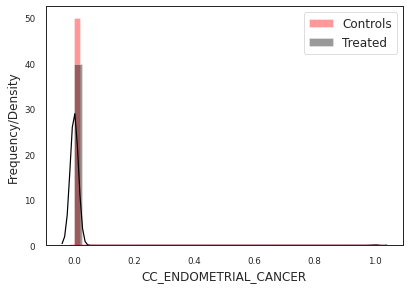

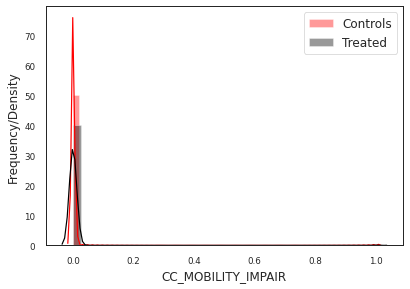

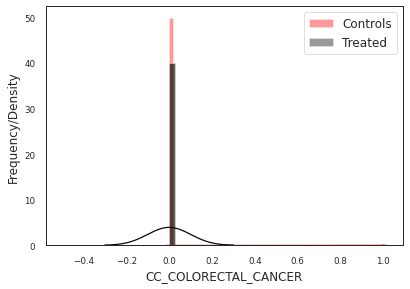

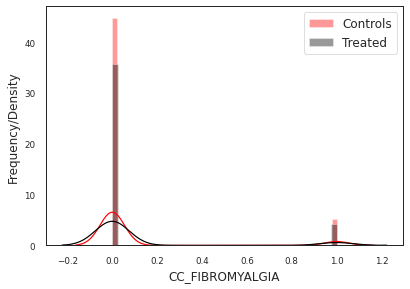

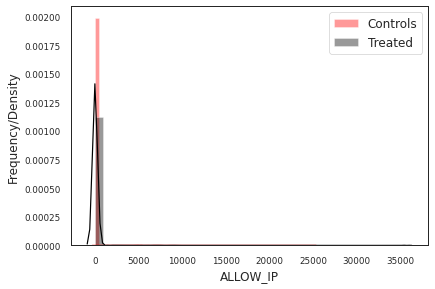

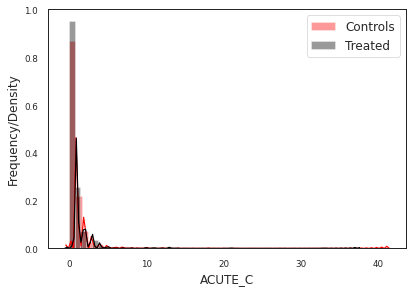

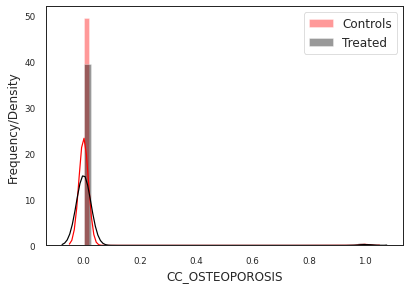

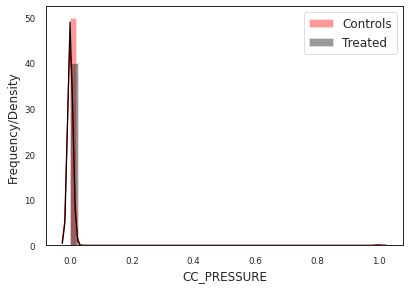

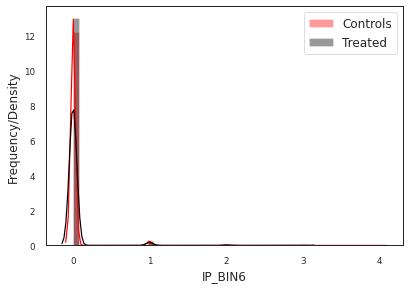

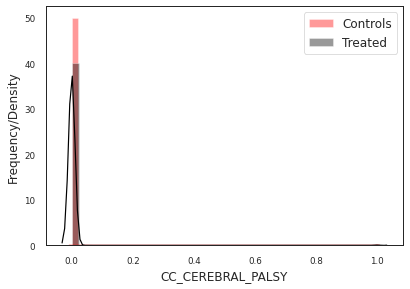

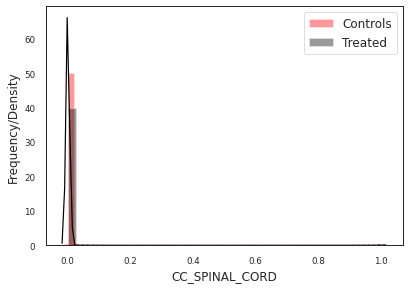

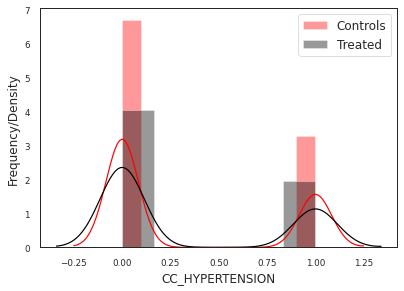

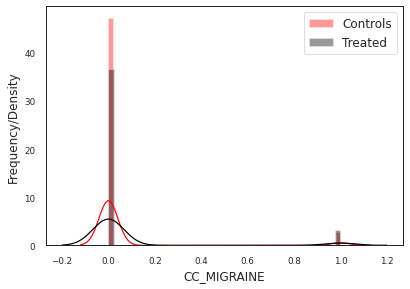

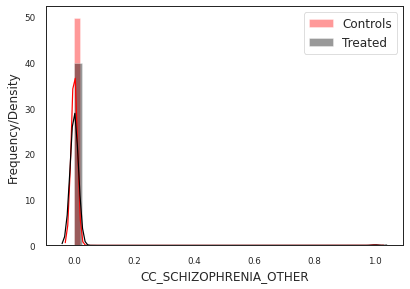

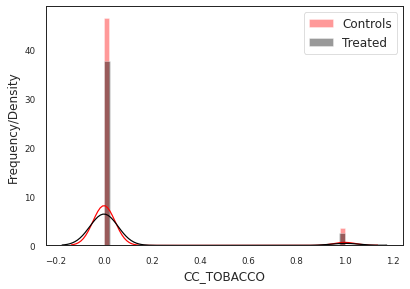

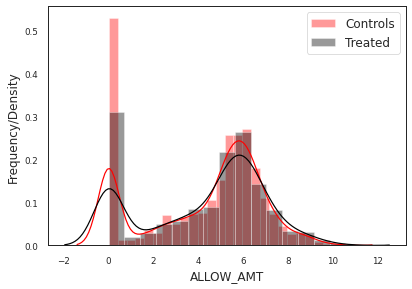

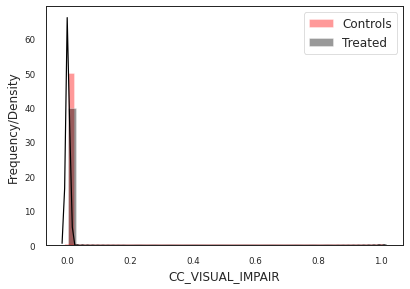

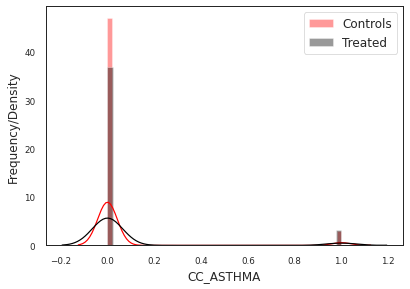

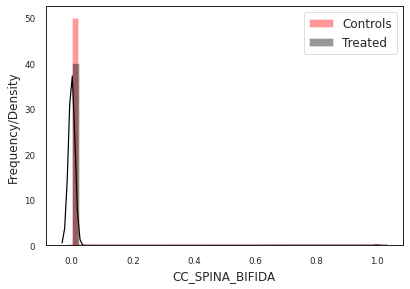

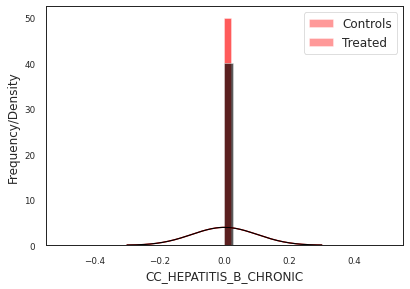

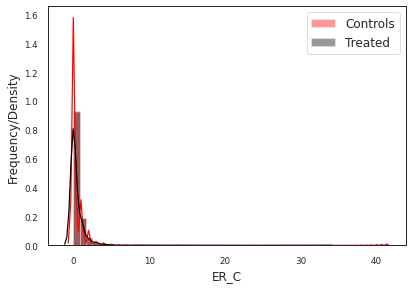

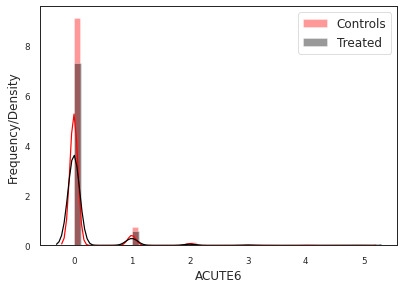

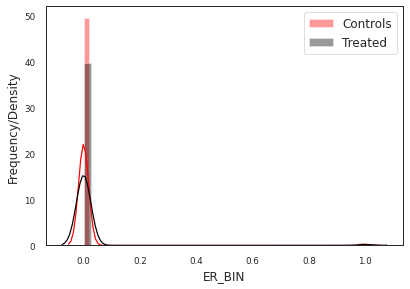

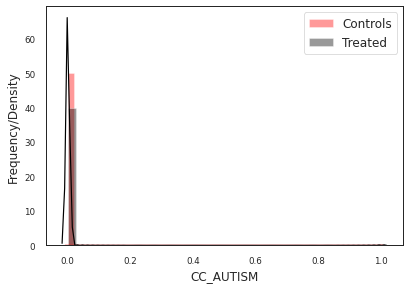

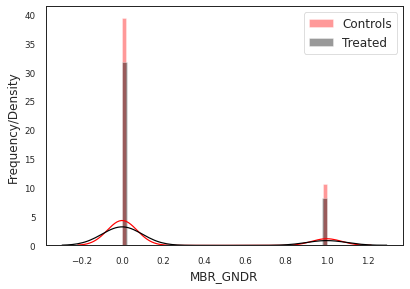

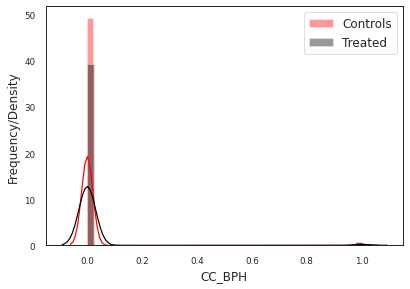

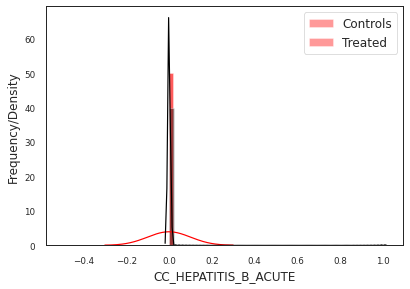

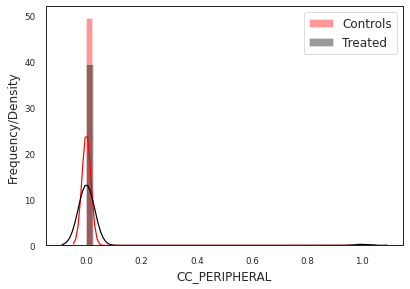

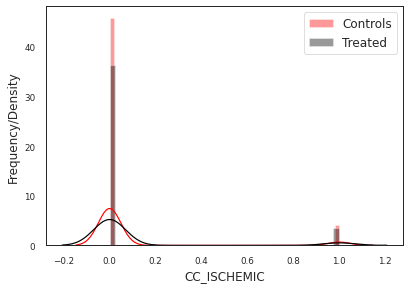

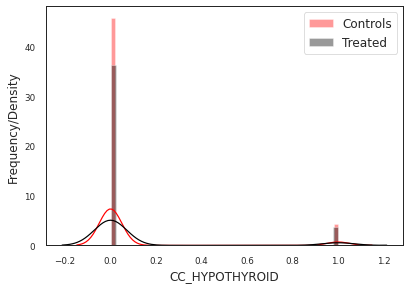

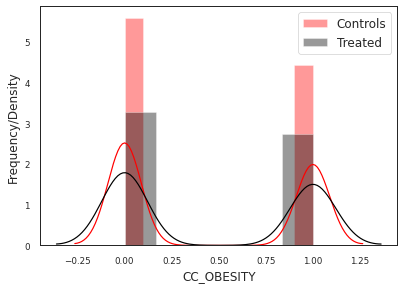

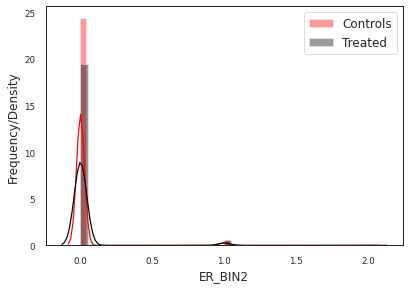

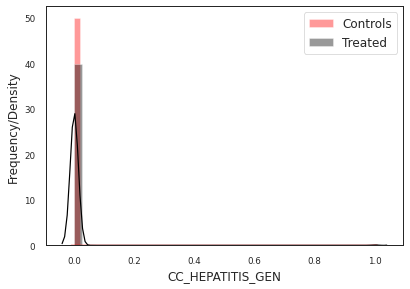

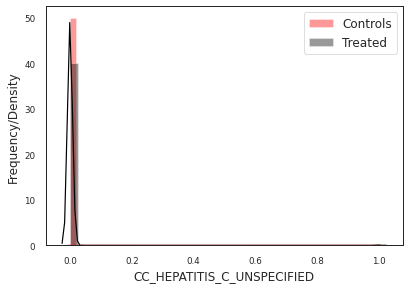

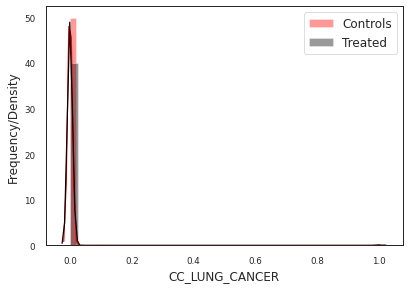

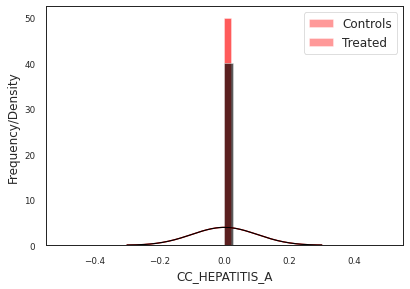

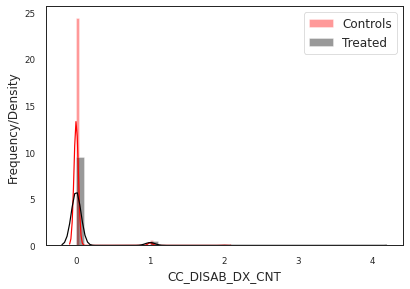

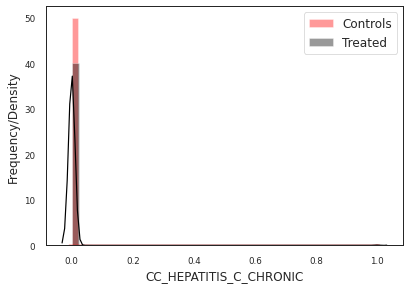

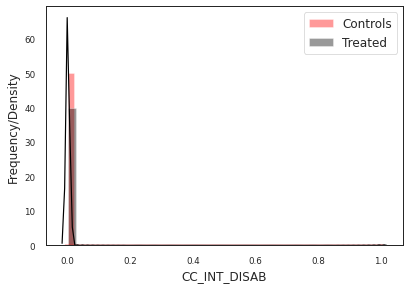

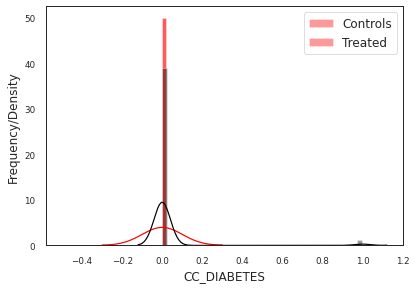

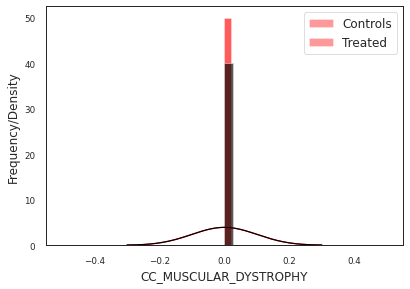

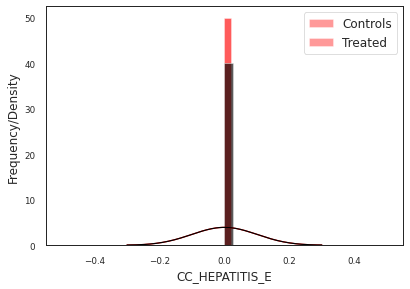

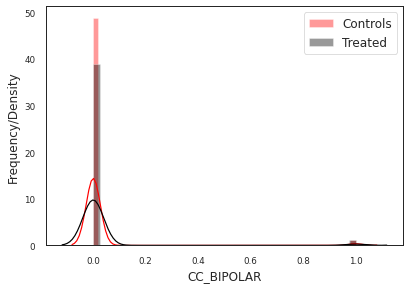

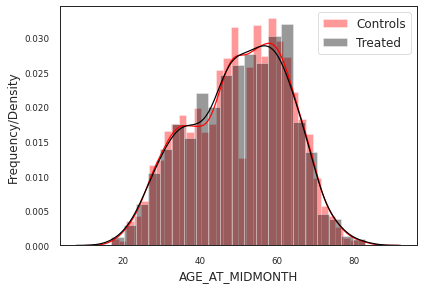

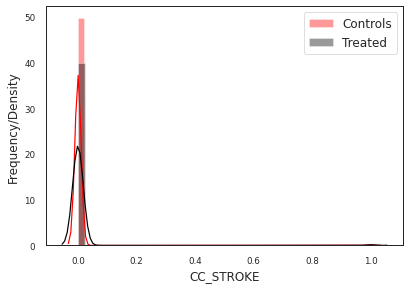

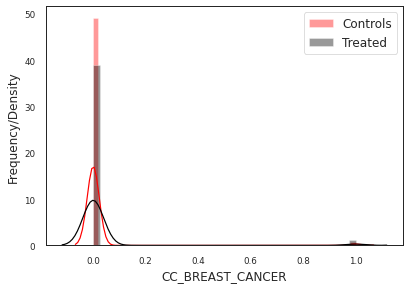

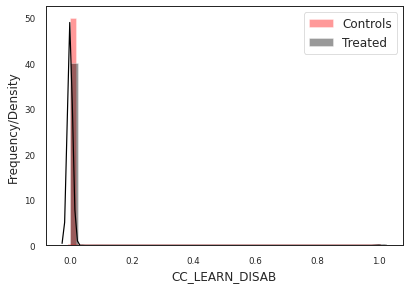

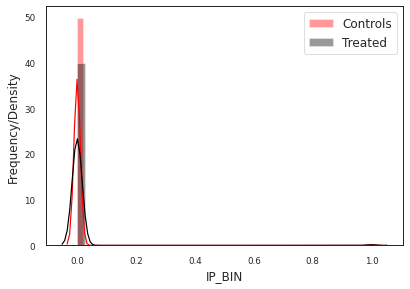

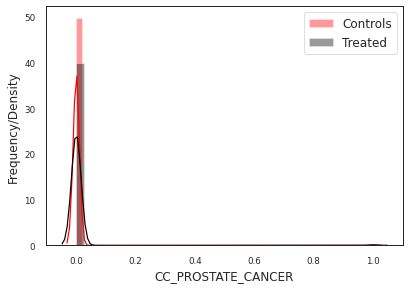

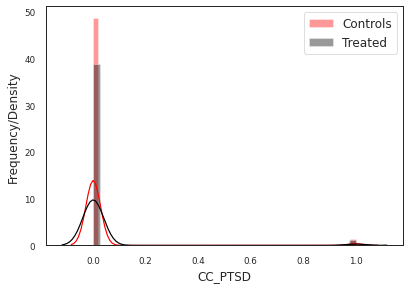

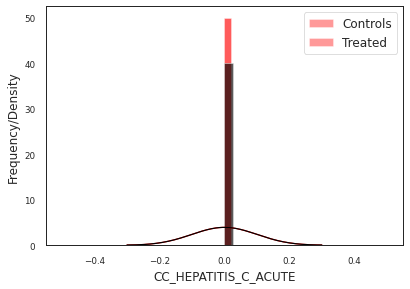

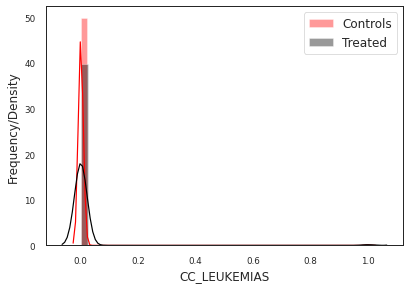

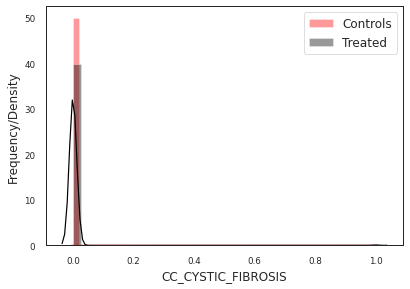

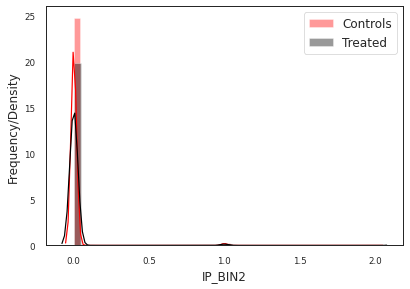

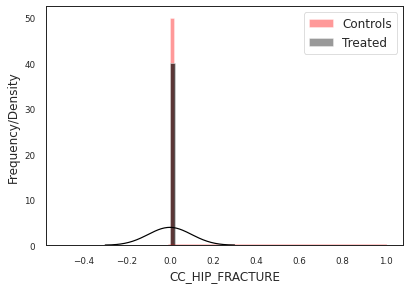

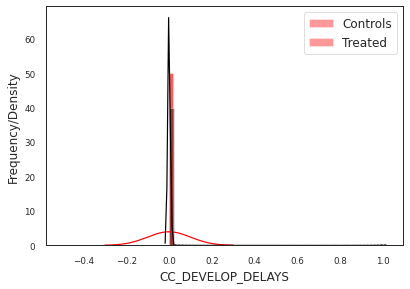

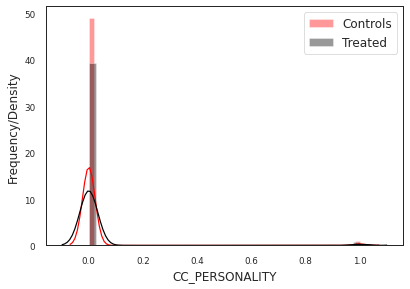

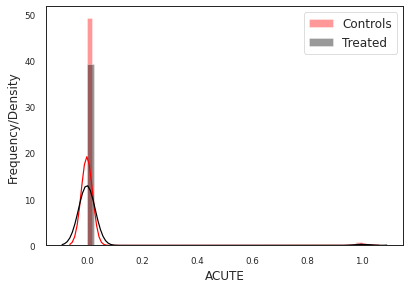

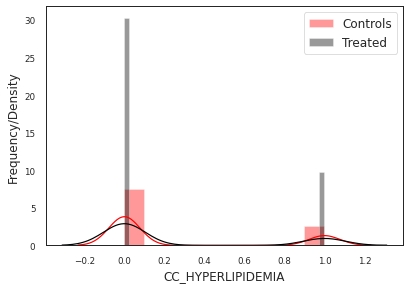

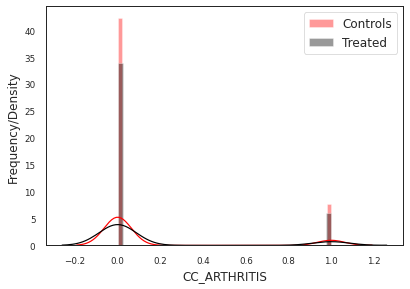

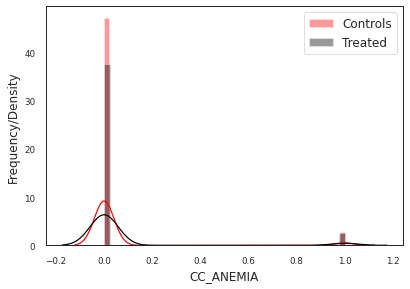

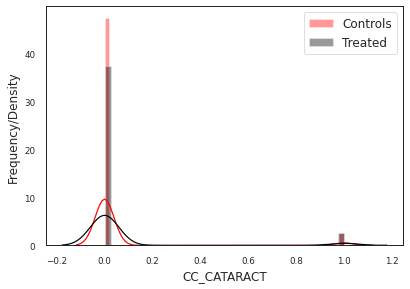

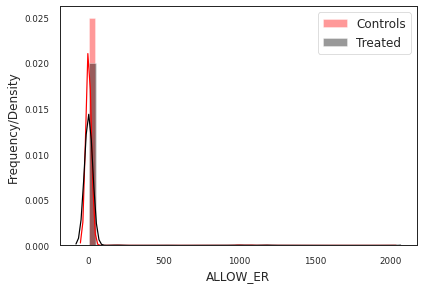

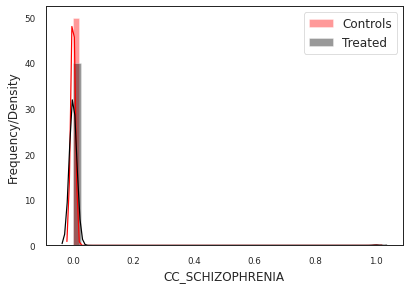

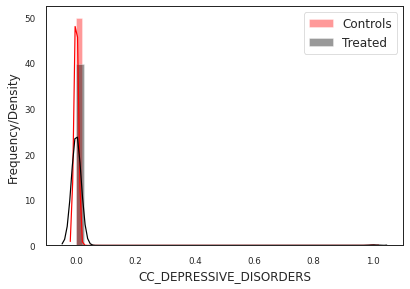

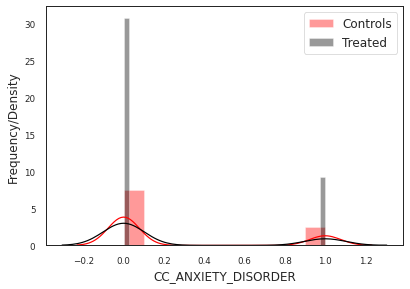

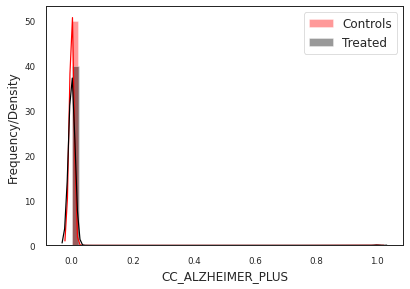

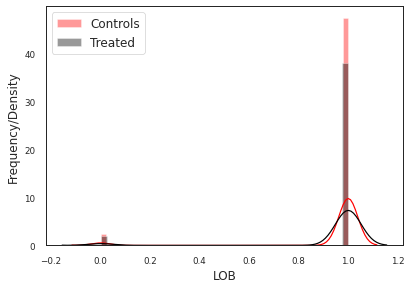

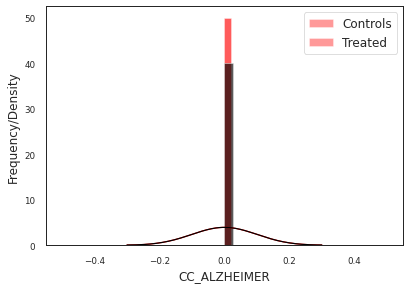

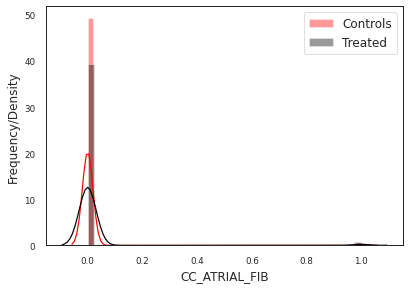

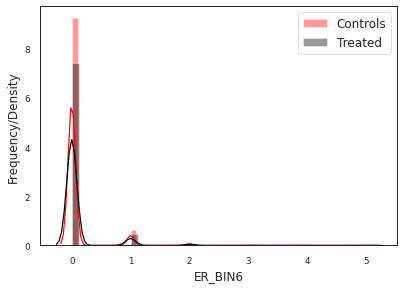

In [26]:
#%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

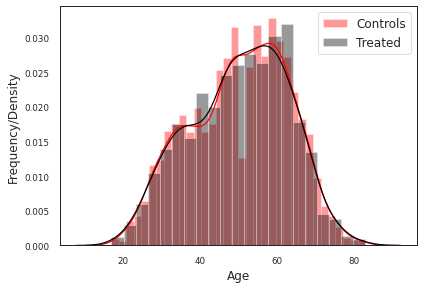

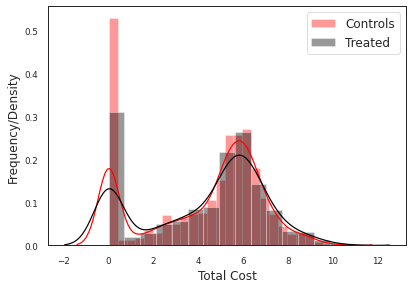

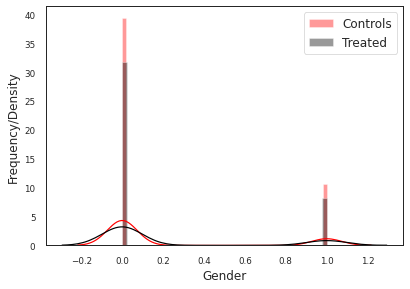

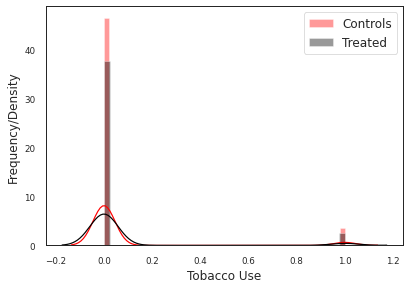

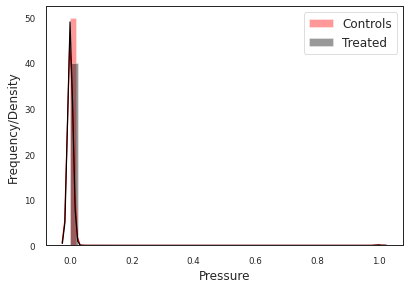

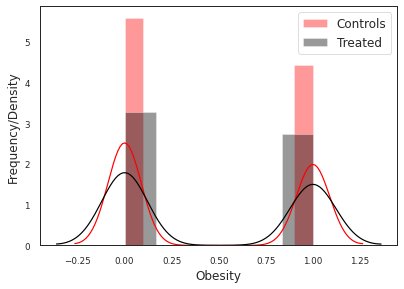

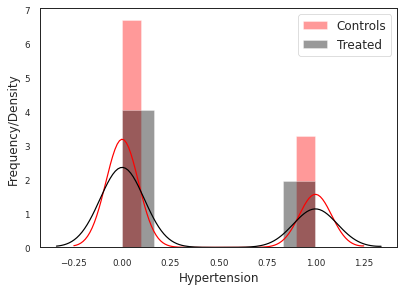

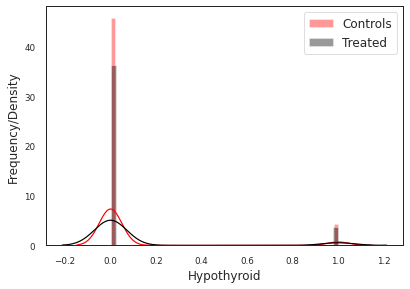

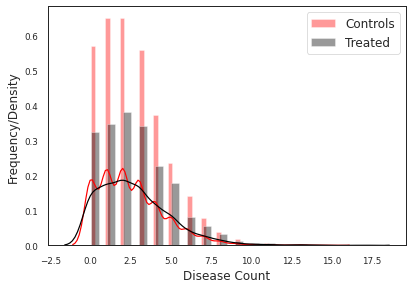

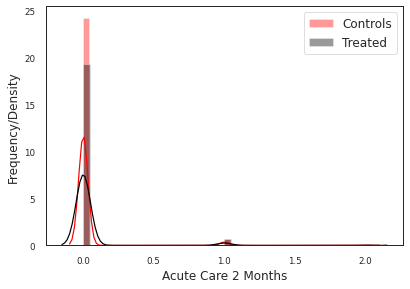

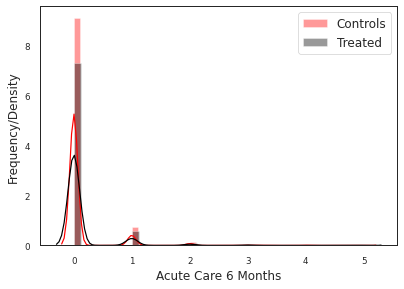

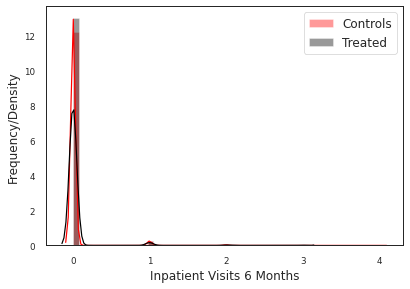

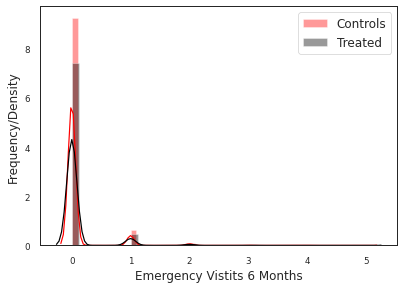

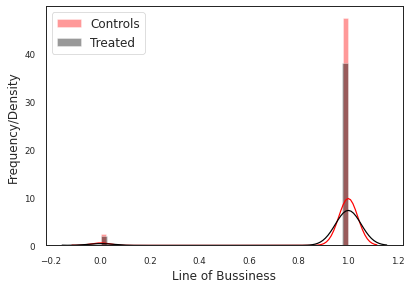

In [27]:
#%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

### Save enhanced stats arrays(these will be used at the end)
Arrays with: Statistics in first day, statistics  in the span of monthsm statistiocs from selected columns and all columns

In [28]:
arrays = [conds_first, full_first, conds_firstAllCols, full_firstAllCols,
         conds, full, conds_AllCols, full_AllCols]
names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols',
         'conds', 'full', 'conds_AllCols', 'full_AllCols']
save_arrays2(arrays, names, base_path+'tables/stats/')